**Trabajo final de Master Data Science**

Jorge Arias Martín
# UOC

In [69]:
!nvidia-smi

Fri Oct 25 09:23:58 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    59W / 149W |    154MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#PREPARACION DEL ENTORNO
## PASO 1
En primer lugar instalaremos algunas de lsa librerias necesarias para ejecutar el código de carga y visualización de datos.

In [3]:
!pip install pmdarima
!pip install pyflux
!pip install pandas

     |████████████████████████████████| 1.1MB 2.8MB/s 
     |████████████████████████████████| 1.3MB 2.8MB/s 
     |████████████████████████████████| 962kB 17.6MB/s 
  Created wheel for pyflux: filename=pyflux-0.4.15-cp36-cp36m-linux_x86_64.whl size=4656522 sha256=06f00abf467e61ef01aed48e42268687f68c9d9714f51cbbd1dc18c6315d8a67
  Stored in directory: /root/.cache/pip/wheels/36/24/09/d18fa4f926cc90598d23ebd09fb4b0fd7b3dd1d2f506b952de
Successfully built pyflux


## PASO 2
Importamos algunas de las librerias requeridas por el codigo

In [0]:
import numpy as np
import pandas as pd
import os
import pyflux as pf
import statsmodels.api as sm
import math

from pandas import datetime
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from google.colab import drive




# DATOS DE ENERGIA
## PASO 3
En este caso, estamos utilizando el repositorio de Google Drive para almacenar los ficheros, importando el fichero con los datos de consumo diario proporcionados


In [7]:
drive.mount('/content/gdrive')

daily=pd.read_csv('gdrive/My Drive/PERSONAL/MASTER_DATA_SCIENCE/TFM/smart-meters-in-london/daily_dataset.csv')
len (daily)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


3510433

## PASO 4
Generamos el fichero **energy.csv** a partir de los datos aportados por Kaggel en la carpeta **daily_dataset**

In [0]:
for num in range(0,112):
    df = pd.read_csv("gdrive/My Drive/PERSONAL/MASTER_DATA_SCIENCE/TFM/smart-meters-in-london/daily_dataset/block_"+str(num)+".csv")
    df = df[['day','LCLid','energy_sum']]
    df.reset_index()
    df.to_csv("hc_"+str(num)+".csv")

fout= open("energy.csv","a")

for line in open("hc_0.csv"):
    fout.write(line)
    
for num in range(0,112):
    f = open("hc_"+str(num)+".csv")
    f.readline() # skip the header
    for line in f:
         fout.write(line)
    f.close()
fout.close()

In [9]:

acorn_details=pd.read_csv('gdrive/My Drive/PERSONAL/MASTER_DATA_SCIENCE/TFM/smart-meters-in-london/acorn_details.csv', encoding='cp1252')
print (acorn_details.info())
print (len (acorn_details))
print (acorn_details.describe())
print (acorn_details.head(10))
print (acorn_details.count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826 entries, 0 to 825
Data columns (total 20 columns):
MAIN CATEGORIES    826 non-null object
CATEGORIES         826 non-null object
REFERENCE          826 non-null object
ACORN-A            826 non-null float64
ACORN-B            826 non-null float64
ACORN-C            826 non-null float64
ACORN-D            826 non-null float64
ACORN-E            826 non-null float64
ACORN-F            826 non-null float64
ACORN-G            826 non-null float64
ACORN-H            826 non-null float64
ACORN-I            826 non-null float64
ACORN-J            826 non-null float64
ACORN-K            826 non-null float64
ACORN-L            826 non-null float64
ACORN-M            826 non-null float64
ACORN-N            826 non-null float64
ACORN-O            826 non-null float64
ACORN-P            826 non-null float64
ACORN-Q            826 non-null float64
dtypes: float64(17), object(3)
memory usage: 129.2+ KB
None
826
           ACORN-A     ACORN-B    

In [10]:
informations_households=pd.read_csv('gdrive/My Drive/PERSONAL/MASTER_DATA_SCIENCE/TFM/smart-meters-in-london/informations_households.csv', encoding='cp1252')
print (informations_households.info())
print (len (informations_households))
print (informations_households.describe())
print (informations_households.head(10))
print (informations_households.count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5566 entries, 0 to 5565
Data columns (total 5 columns):
LCLid            5566 non-null object
stdorToU         5566 non-null object
Acorn            5566 non-null object
Acorn_grouped    5566 non-null object
file             5566 non-null object
dtypes: object(5)
memory usage: 217.5+ KB
None
5566
            LCLid stdorToU    Acorn Acorn_grouped      file
count        5566     5566     5566          5566      5566
unique       5566        2       19             5       112
top     MAC002453      Std  ACORN-E      Affluent  block_94
freq            1     4443     1567          2192        50
       LCLid stdorToU    Acorn Acorn_grouped     file
0  MAC005492      ToU   ACORN-        ACORN-  block_0
1  MAC001074      ToU   ACORN-        ACORN-  block_0
2  MAC000002      Std  ACORN-A      Affluent  block_0
3  MAC003613      Std  ACORN-A      Affluent  block_0
4  MAC003597      Std  ACORN-A      Affluent  block_0
5  MAC003579      Std  ACORN

In [11]:
uk_bank_holidays=pd.read_csv('gdrive/My Drive/PERSONAL/MASTER_DATA_SCIENCE/TFM/smart-meters-in-london/uk_bank_holidays.csv', encoding='cp1252')
print (uk_bank_holidays.info())
print (len (uk_bank_holidays))
print (uk_bank_holidays.describe())
print (uk_bank_holidays.head(10))
print (uk_bank_holidays.count())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
Bank holidays    25 non-null object
Type             25 non-null object
dtypes: object(2)
memory usage: 528.0+ bytes
None
25
       Bank holidays        Type
count             25          25
unique            25          11
top       2012-09-04  Boxing Day
freq               1           3
  Bank holidays                                          Type
0    2012-12-26                                    Boxing Day
1    2012-12-25                                 Christmas Day
2    2012-08-27                           Summer bank holiday
3    2012-05-06  Queen?s Diamond Jubilee (extra bank holiday)
4    2012-04-06          Spring bank holiday (substitute day)
5    2012-07-05                        Early May bank holiday
6    2012-09-04                                 Easter Monday
7    2012-06-04                                   Good Friday
8    2012-02-01               New Year?s Day (subs

In [12]:
weather_daily_darksky=pd.read_csv('gdrive/My Drive/PERSONAL/MASTER_DATA_SCIENCE/TFM/smart-meters-in-london/weather_daily_darksky.csv', encoding='cp1252')
print (weather_daily_darksky.info())
print (len (weather_daily_darksky))
print (weather_daily_darksky.describe())
print (weather_daily_darksky.head(10))
print (weather_daily_darksky.count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 32 columns):
temperatureMax                 882 non-null float64
temperatureMaxTime             882 non-null object
windBearing                    882 non-null int64
icon                           882 non-null object
dewPoint                       882 non-null float64
temperatureMinTime             882 non-null object
cloudCover                     881 non-null float64
windSpeed                      882 non-null float64
pressure                       882 non-null float64
apparentTemperatureMinTime     882 non-null object
apparentTemperatureHigh        882 non-null float64
precipType                     882 non-null object
visibility                     882 non-null float64
humidity                       882 non-null float64
apparentTemperatureHighTime    882 non-null object
apparentTemperatureLow         882 non-null float64
apparentTemperatureMax         882 non-null float64
uvIndex            

In [13]:
weather_hourly_darksky=pd.read_csv('gdrive/My Drive/PERSONAL/MASTER_DATA_SCIENCE/TFM/smart-meters-in-london/weather_hourly_darksky.csv', encoding='cp1252')
print (weather_hourly_darksky.info())
print (len (weather_hourly_darksky))
print (weather_hourly_darksky.describe())
print (weather_hourly_darksky.head(10))
print (weather_hourly_darksky.count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21165 entries, 0 to 21164
Data columns (total 12 columns):
visibility             21165 non-null float64
windBearing            21165 non-null int64
temperature            21165 non-null float64
time                   21165 non-null object
dewPoint               21165 non-null float64
pressure               21152 non-null float64
apparentTemperature    21165 non-null float64
windSpeed              21165 non-null float64
precipType             21165 non-null object
icon                   21165 non-null object
humidity               21165 non-null float64
summary                21165 non-null object
dtypes: float64(7), int64(1), object(4)
memory usage: 1.9+ MB
None
21165
         visibility   windBearing  ...     windSpeed      humidity
count  21165.000000  21165.000000  ...  21165.000000  21165.000000
mean      11.166485    195.685897  ...      3.905215      0.781829
std        3.099337     90.629453  ...      2.026854      0.140369
min 

In [14]:
informations_households=pd.read_csv('gdrive/My Drive/PERSONAL/MASTER_DATA_SCIENCE/TFM/smart-meters-in-london/informations_households.csv')
len (informations_households)

5566

## PASO 5
Cargamos el fichero generado en el dataframe **energy**

In [15]:
energy=pd.read_csv('/content/energy.csv')
print (energy.info())
print (len (energy))
print (energy.describe())
print (energy.head(10))
print (energy.count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3536007 entries, 0 to 3536006
Data columns (total 4 columns):
Unnamed: 0    int64
day           object
LCLid         object
energy_sum    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 107.9+ MB
None
3536007
         Unnamed: 0    energy_sum
count  3.536007e+06  3.535977e+06
mean   1.576990e+04  1.020674e+01
std    9.194901e+03  9.307041e+00
min    0.000000e+00  0.000000e+00
25%    7.823000e+03  4.698000e+00
50%    1.569700e+04  7.852000e+00
75%    2.359000e+04  1.264100e+01
max    3.616700e+04  3.325560e+02
   Unnamed: 0         day      LCLid  energy_sum
0           0  2012-10-12  MAC000002       7.098
1           1  2012-10-13  MAC000002      11.087
2           2  2012-10-14  MAC000002      13.223
3           3  2012-10-15  MAC000002      10.257
4           4  2012-10-16  MAC000002       9.769
5           5  2012-10-17  MAC000002      10.885
6           6  2012-10-18  MAC000002      10.751
7           7  2012-10-19  MA

## PASO 6
Ordenando el contenido del dataframe por fechas, esto se realiza para determinar el número de hogares que generaron los datos, probablemente por que la implemnetación del sistema de medida fue paulatino y podria arrojar datos confusos de consumos en los primero días de la instalación.

In [16]:
housecount = energy.groupby('day')[['LCLid']].nunique()
housecount.head(4)

LCLid
day              
2011-11-23     13
2011-11-24     25
2011-11-25     32
2011-11-26     41

## PASO 7

Comprobamos la inconsistencia de los datos por hogar, por lo tanto no pueden utilizarse este dato para realizar la predicción, así que se utilizará la suma de la energía global para calcular la predicción global y de esta forma normalizamos los datos energéticos.

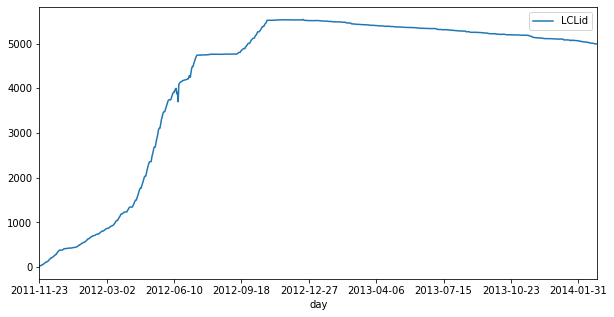

In [17]:
housecount.plot(figsize=(10,5))

Realizamos la suma de los datos energéticos por día

In [18]:
energy = energy.groupby('day')[['energy_sum']].sum()
energy = energy.merge(housecount, on = ['day'])
energy = energy.reset_index()
energy.count()

day           829
energy_sum    829
LCLid         829
dtype: int64

In [19]:
energy.describe()

energy_sum        LCLid
count    829.000000   829.000000
mean   43535.325676  4234.539204
std    20550.594031  1789.994799
min       90.385000    13.000000
25%    34665.436003  4084.000000
50%    46641.160997  5138.000000
75%    59755.616996  5369.000000
max    84156.135002  5541.000000

In [20]:
energy['avg_energy'] =  energy['energy_sum']/energy['LCLid']
print("Starting Point of Data at Day Level",min(energy.day))
print("Ending Point of Data at Day Level",max(energy.day))

Starting Point of Data at Day Level 2011-11-23
Ending Point of Data at Day Level 2014-02-28


## PASO 8
Añadimos el dataframe de los datos climáticos **weather_daily_darksky.csv**

In [21]:
weather = pd.read_csv('gdrive/My Drive/PERSONAL/MASTER_DATA_SCIENCE/TFM/smart-meters-in-london/weather_daily_darksky.csv')
weather.head(4)

temperatureMax   temperatureMaxTime  ...  apparentTemperatureLowTime moonPhase
0           11.96  2011-11-11 23:00:00  ...         2011-11-11 19:00:00      0.52
1            8.59  2011-12-11 14:00:00  ...         2011-12-12 08:00:00      0.53
2           10.33  2011-12-27 02:00:00  ...         2011-12-28 00:00:00      0.10
3            8.07  2011-12-02 23:00:00  ...         2011-12-02 19:00:00      0.25

[4 rows x 32 columns]

In [22]:
weather.describe()

temperatureMax  windBearing  ...  apparentTemperatureMin   moonPhase
count      882.000000   882.000000  ...              882.000000  882.000000
mean        13.660113   195.702948  ...                5.738039    0.500930
std          6.182744    89.340783  ...                6.048746    0.287022
min         -0.060000     0.000000  ...               -8.880000    0.000000
25%          9.502500   120.500000  ...                1.105000    0.260000
50%         12.625000   219.000000  ...                4.885000    0.500000
75%         17.920000   255.000000  ...               11.277500    0.750000
max         32.400000   359.000000  ...               20.540000    0.990000

[8 rows x 17 columns]

Normalizamos la columna **time** en el dataframe de **weather** para convertirla en **timestam** con formato AÑO/MES/DÍA

In [0]:
weather['day']=  pd.to_datetime(weather['time']) # day is given as timestamp
weather['day']=  pd.to_datetime(weather['day'],format='%Y%m%d').dt.date
# selecting numeric variables
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day']]
weather = weather.dropna()

Normalizamos la columna **time** en el dataframe de **energy** para convertirla en **timestam** con formato AÑO/MES/DÍA y la unimos con la coincidencia de día con el dataframe weather creando el nueva dataframe **weather_energy**

In [24]:
energy['day']=  pd.to_datetime(energy['day'],format='%Y-%m-%d').dt.date
weather_energy =  energy.merge(weather,on='day')
weather_energy.head(2)
weather_energy

day    energy_sum  ...  apparentTemperatureMin  moonPhase
0    2011-11-23     90.385000  ...                    2.18       0.94
1    2011-11-24    213.412000  ...                    7.01       0.97
2    2011-11-25    303.993000  ...                    4.84       0.01
3    2011-11-26    420.976000  ...                    4.69       0.05
4    2011-11-27    444.883001  ...                    2.94       0.08
..          ...           ...  ...                     ...        ...
823  2014-02-24  52867.660004  ...                    5.52       0.82
824  2014-02-25  52330.109999  ...                    3.89       0.86
825  2014-02-26  51804.199995  ...                    1.67       0.90
826  2014-02-27  52580.878999  ...                    1.41       0.93
827  2014-02-28   1056.076000  ...                    0.82       0.97

[828 rows x 21 columns]

# TEMPERATURA
## PASO 9
Podemos intuir que la energía y la temperatura tienen una relación inversa

Los picos en uno que aparecen coincidentes con los canales en el otro. Esto confirma la intuición de las compañias electricas de que con temperaturas bajas, es probable que aumente el consumo de energía a través de aparatos calentadores

La gráfica muestra la temperatura maxima y mínima con los colores naranja y rosa respectivamente, junto con el consume eléctrico en color azul.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


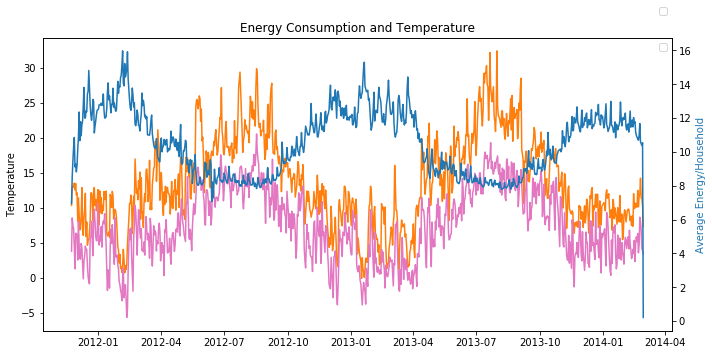

In [25]:
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(weather_energy.day, weather_energy.temperatureMax, color = 'tab:orange')
ax1.plot(weather_energy.day, weather_energy.temperatureMin, color = 'tab:pink')
ax1.set_ylabel('Temperature')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()

# HUMEDAD
## Paso 10
La humedad y el consumo medio de energía parecen tener la misma tendencia  de correlacción positiva


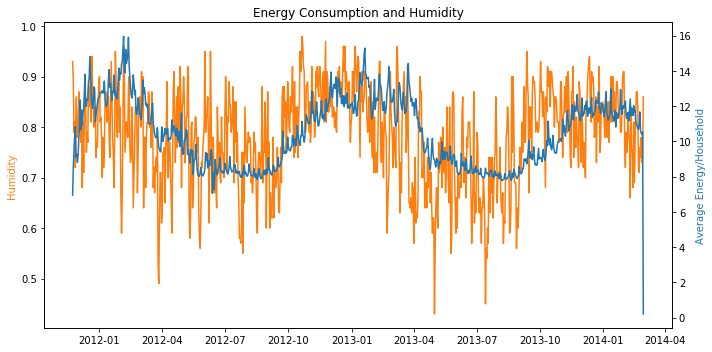

In [26]:
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(weather_energy.day, weather_energy.humidity, color = 'tab:orange')
ax1.set_ylabel('Humidity',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Humidity')
fig.tight_layout()
plt.show()

# CIELOS CUBIERTOS
## Paso 11
El valor de la cobertura de las nubes parece seguir el mismo patrón que el consumo de energía; mostrando multicolinealidad con la humedad

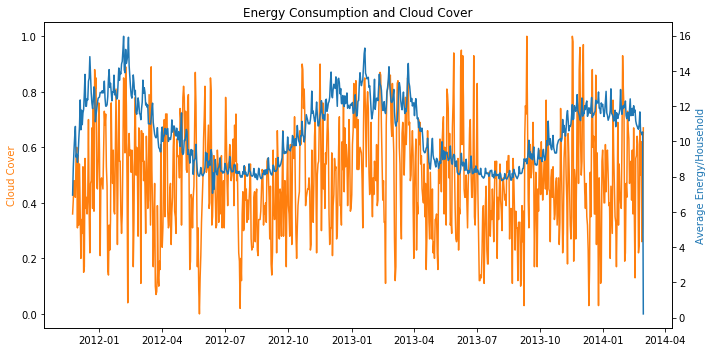

In [27]:
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(weather_energy.day, weather_energy.cloudCover, color = 'tab:orange')
ax1.set_ylabel('Cloud Cover',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Cloud Cover')
fig.tight_layout()
plt.show()

# VISIBILIDAD
## Paso 12
El factor de visibilidad no parece afectar el consumo de energía en absoluto, ya que la visibilidad es probablemente un factor en el exterior, es poco probable que su aumento o disminución afecte el consumo de energía dentro de un hogar, ; mostrando multicolinealidad con la humedad

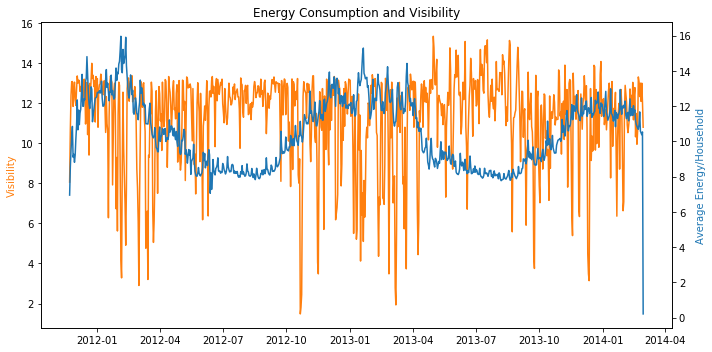

In [28]:
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(weather_energy.day, weather_energy.visibility, color = 'tab:orange')
ax1.set_ylabel('Visibility',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Visibility')
fig.tight_layout()
plt.show()

# VELOCIDAD DEL VIENTO
## Paso 13
Al igual que la visibilidad, la velocidad del viento parece ser un factor al aire libre que no afecta el consumo de energía como tal no mostrando correlacción y sin mostrar multicolinealidad con otros factores

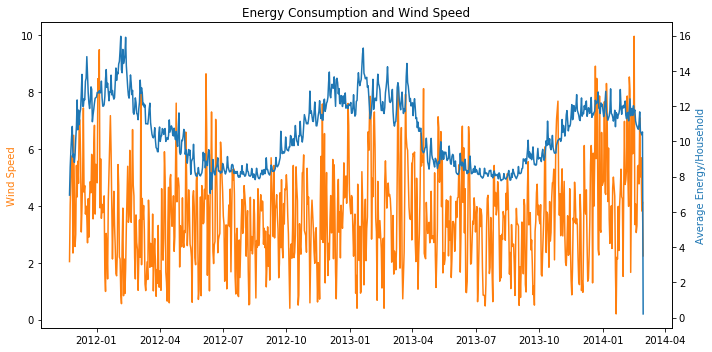

In [29]:
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(weather_energy.day, weather_energy.windSpeed, color = 'tab:orange')
ax1.set_ylabel('Wind Speed',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Wind Speed')
fig.tight_layout()
plt.show()

# INDICE UV
## Paso 14
El índice UV tiene una relación inversa con el consumo de energía, teniendo multicolinealidad con la temperatura como en el caso de la variable **Rocio**

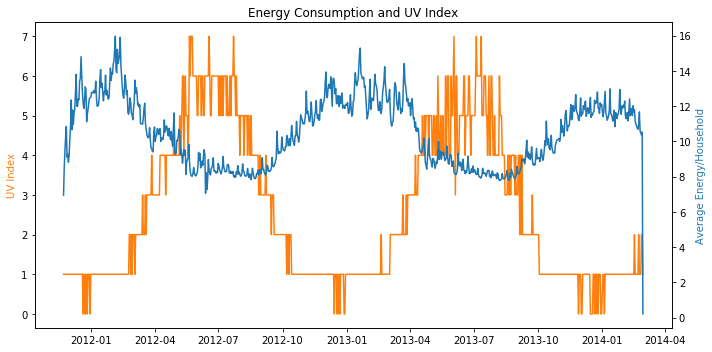

In [30]:
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(weather_energy.day, weather_energy.uvIndex, color = 'tab:orange')
ax1.set_ylabel('UV Index',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and UV Index')
fig.tight_layout()
plt.show()

# ROCIO
## Paso 15
El punto de rocío es una función de la humedad y la temperatura, por lo que muestra una relación similar con el consumo de energía, considerando multicolinealidad con la temperatura como en el caso del **Indice UV**

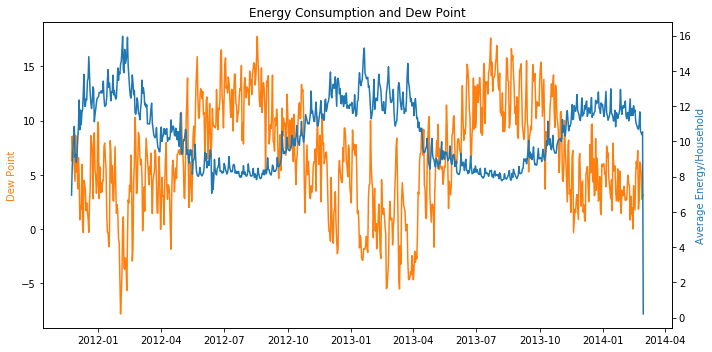

In [31]:
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(weather_energy.day, weather_energy.dewPoint, color = 'tab:orange')
ax1.set_ylabel('Dew Point',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Dew Point')
fig.tight_layout()
plt.show()

# FASE LUNAR
## Paso 16
La fase lunar no parece que tenga repercusión el el consumo energético.

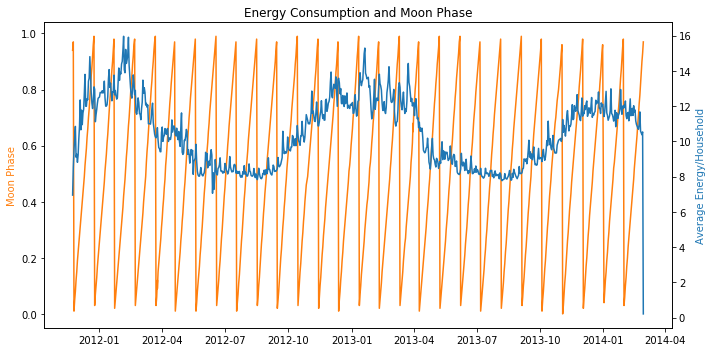

In [32]:
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(weather_energy.day, weather_energy.moonPhase, color = 'tab:orange')
ax1.set_ylabel('Moon Phase',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Moon Phase')
fig.tight_layout()
plt.show()

# PRESION ATMOSFERICA
## Paso 17
La presión atmosfericano parece que tenga repercusión el el consumo energético.

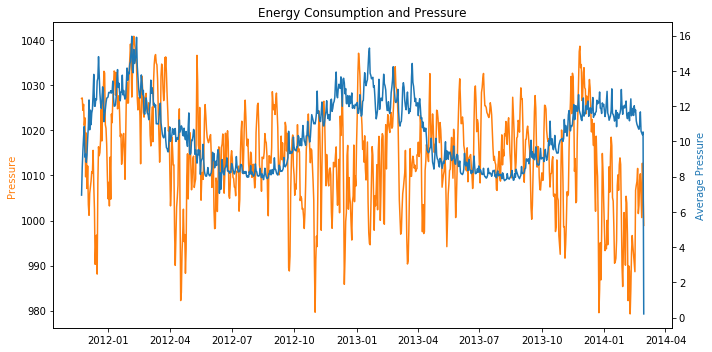

In [33]:
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(weather_energy.day, weather_energy.pressure, color = 'tab:orange')
ax1.set_ylabel('Pressure',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Pressure',color = 'tab:blue')
plt.title('Energy Consumption and Pressure')
fig.tight_layout()
plt.show()

# CORRELACCIÓN ENTRE VARIABLES
## Paso 18

Vemos en la matríz de correlacción

In [34]:
cor_matrix = weather_energy[['avg_energy','temperatureMax','dewPoint', 'cloudCover', 'windSpeed','pressure', 'visibility', 'humidity','uvIndex', 'moonPhase']].corr()
cor_matrix

avg_energy  temperatureMax  ...   uvIndex  moonPhase
avg_energy        1.000000       -0.846965  ... -0.733171  -0.031716
temperatureMax   -0.846965        1.000000  ...  0.696497   0.003636
dewPoint         -0.755901        0.865038  ...  0.486692  -0.008239
cloudCover        0.241779       -0.333409  ... -0.248695  -0.062126
windSpeed         0.149624       -0.153602  ... -0.152634  -0.023273
pressure         -0.028851        0.118933  ...  0.100774   0.038462
visibility       -0.246404        0.259108  ...  0.240485   0.062813
humidity          0.361237       -0.404899  ... -0.533919  -0.013997
uvIndex          -0.733171        0.696497  ...  1.000000   0.012833
moonPhase        -0.031716        0.003636  ...  0.012833   1.000000

[10 rows x 10 columns]

##CLIMA HAY POR DÍA
#Paso 19
El clima tiene multiples variables , que no todas son útiles, ahora vamos a discretizar los valores para tener el clima que hacía por cada día

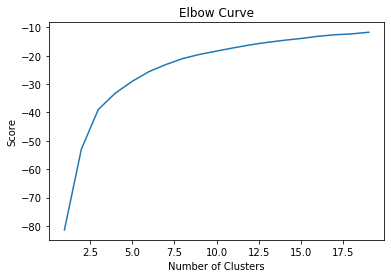

In [35]:
scaler = MinMaxScaler()
weather_scaled = scaler.fit_transform(weather_energy[['temperatureMax','humidity','windSpeed']])

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(weather_scaled).score(weather_scaled) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

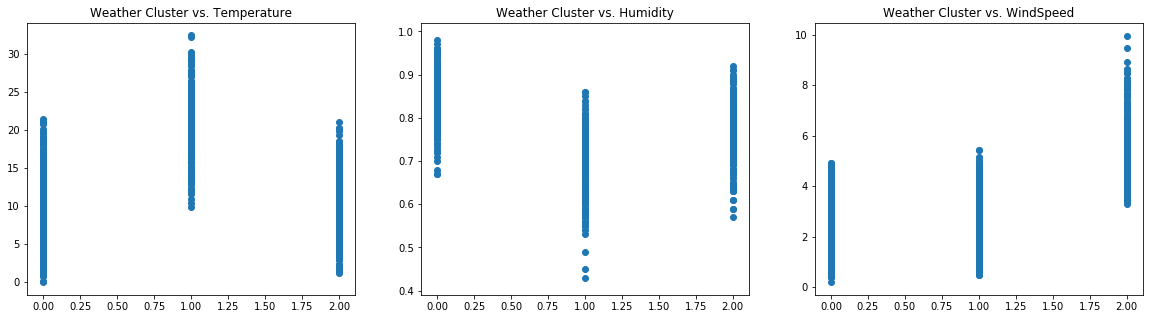

In [36]:
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
kmeans.fit(weather_scaled)
weather_energy['weather_cluster'] = kmeans.labels_

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.scatter(weather_energy.weather_cluster,weather_energy.temperatureMax)
plt.title('Weather Cluster vs. Temperature')
plt.subplot(1, 3, 2)
plt.scatter(weather_energy.weather_cluster,weather_energy.humidity)
plt.title('Weather Cluster vs. Humidity')
plt.subplot(1, 3, 3)
plt.scatter(weather_energy.weather_cluster,weather_energy.windSpeed)
plt.title('Weather Cluster vs. WindSpeed')

plt.show()


Comprobamos que la agrupación está discretizada para calcular entre 0 y 2 el tipo de clima que hubo por cada día

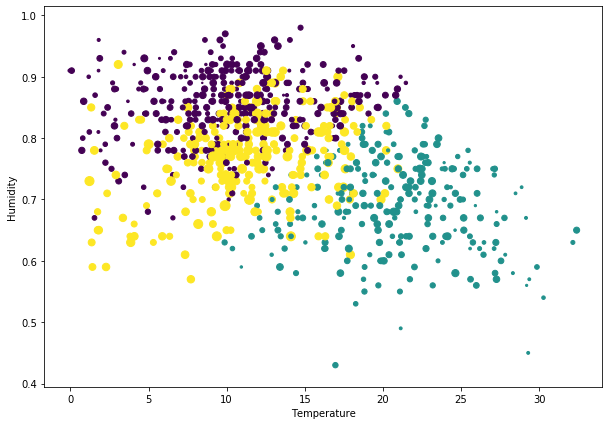

In [37]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.scatter(weather_energy.temperatureMax, 
            weather_energy.humidity, 
            s = weather_energy.windSpeed*10,
            c = weather_energy.weather_cluster)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Humidity')
plt.show()

##DIAS NO LABORABLES
#Paso 20
Añadimos el dataset de días festivos y lo añadimos el dataframe de **weather_energy**

In [38]:
holiday = pd.read_csv('gdrive/My Drive/PERSONAL/MASTER_DATA_SCIENCE/TFM/smart-meters-in-london/uk_bank_holidays.csv')
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'],format='%Y-%m-%d').dt.date
holiday.head(4)

Bank holidays                                          Type
0    2012-12-26                                    Boxing Day
1    2012-12-25                                 Christmas Day
2    2012-08-27                           Summer bank holiday
3    2012-05-06  Queen?s Diamond Jubilee (extra bank holiday)

In [0]:
weather_energy = weather_energy.merge(holiday, left_on = 'day',right_on = 'Bank holidays',how = 'left')
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(),0,1)

##ARIMAX
#Paso 21
En estadística y econometría, en particular en series temporales, un modelo autorregresivo integrado de promedio móvil o ARIMAX es un modelo estadístico que utiliza variaciones y regresiones de datos estadísticos con el fin de encontrar patrones para una predicción hacia el futuro

In [0]:
weather_energy['Year'] = pd.DatetimeIndex(weather_energy['day']).year  
weather_energy['Month'] = pd.DatetimeIndex(weather_energy['day']).month
weather_energy.set_index(['day'],inplace=True)

##DIVIDIR DATOS DE ENTRENAMIENTO
#Paso 22


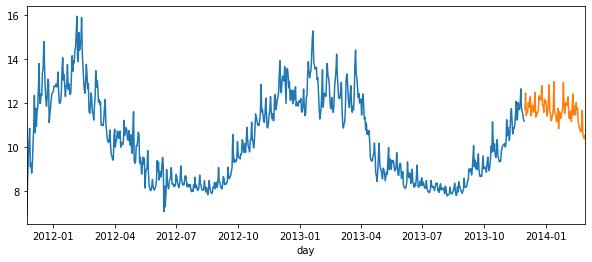

In [41]:
model_data = weather_energy[['avg_energy','weather_cluster','holiday_ind']]
train = model_data.iloc[0:(len(model_data)-90)]
test = model_data.iloc[len(train):(len(model_data)-1)]

train['avg_energy'].plot(figsize=(10,4))
test['avg_energy'].plot(figsize=(10,4))

In [42]:
test.head(5)

avg_energy  weather_cluster  holiday_ind
day                                                 
2013-11-30   11.716715                2            0
2013-12-01   12.465285                0            0
2013-12-02   11.432274                0            0
2013-12-03   11.623989                0            0
2013-12-04   11.569521                0            0

##FUNCIÓN DE AUTO-CORRELACCIÓN TOTAL Y PARCIAL
#Paso 23
La gráfica de autocorrelación muestra una disminución gradual, mientras que la Autocorrelación parcial muestra que hay un fuerte descenso después del primer retraso. 

Esto significa que la mayoría de las autocorrelaciones de orden superior se explican efectivamente por el retraso k = 1. Por lo tanto, la serie muestra AR (AUTOREGRESIVO)

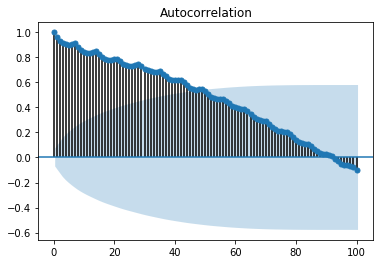

In [43]:
plot_acf(train.avg_energy,lags=100)
plt.show()

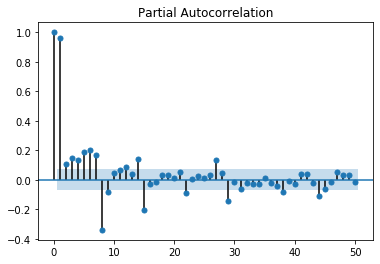

In [44]:
plot_pacf(train.avg_energy,lags=50)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


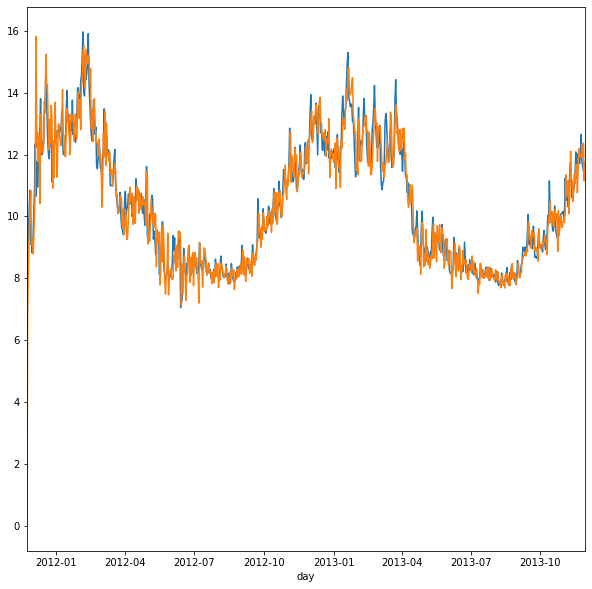

In [45]:
endog = train['avg_energy']
exog = sm.add_constant(train[['weather_cluster','holiday_ind']])
mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(7,1,1),seasonal_order=(1,1, 0, 12),trend='c')
model_fit = mod.fit()
model_fit.summary()
train['avg_energy'].plot(figsize=(10,10))
model_fit.fittedvalues.plot()
plt.show()

In [46]:
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test[['weather_cluster','holiday_ind']]))
test['predicted'] = predict.values
test.tail(5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


avg_energy  weather_cluster  holiday_ind  predicted
day                                                            
2014-02-23   11.673756                2            0  10.670990
2014-02-24   10.586235                2            0  10.880329
2014-02-25   10.476498                2            0  11.413635
2014-02-26   10.375366                2            0  11.531657
2014-02-27   10.537250                2            0  11.312790

In [47]:
test['residual'] = abs(test['avg_energy']-test['predicted'])
MAE = test['residual'].sum()/len(test)
MAPE = (abs(test['residual'])/test['avg_energy']).sum()*100/len(test)
print("MAE:", MAE)
print("MAPE:", MAPE)

MAE: 0.4542465488656246
MAPE: 3.8595594965160687


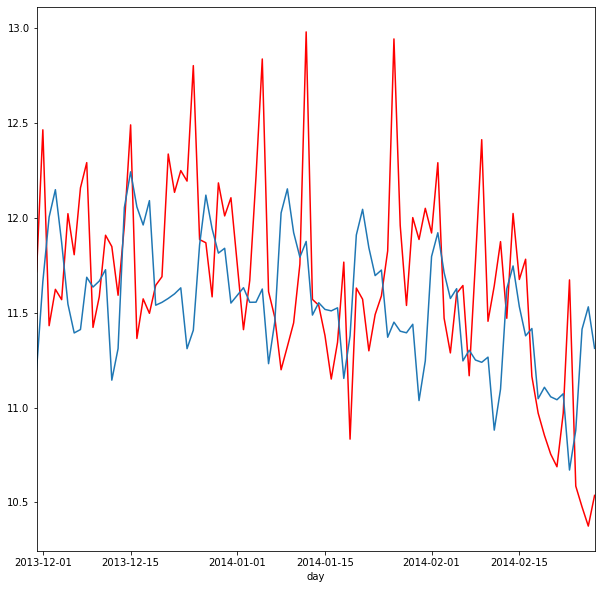

In [48]:
test['avg_energy'].plot(figsize=(10,10),color = 'red')
test['predicted'].plot()
plt.show()

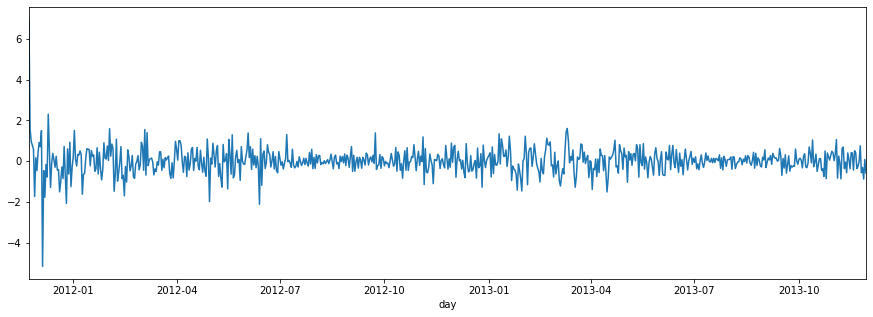

In [49]:
model_fit.resid.plot(figsize= (15,5))

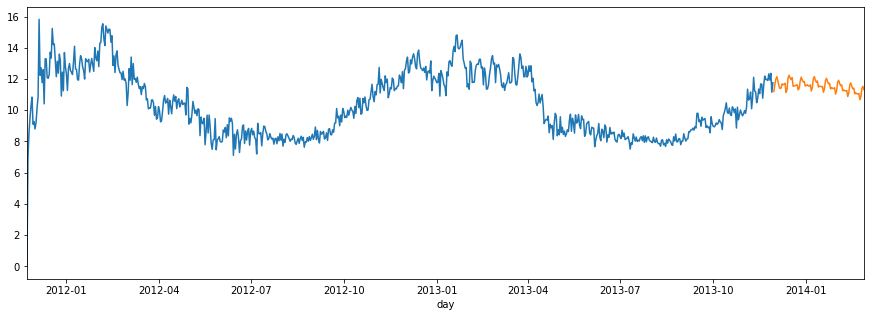

In [50]:
model_fit.fittedvalues.plot(figsize = (15,5))
test.predicted.plot()

In [51]:
test['predicted'].tail(5)

day
2014-02-23    10.670990
2014-02-24    10.880329
2014-02-25    11.413635
2014-02-26    11.531657
2014-02-27    11.312790
Name: predicted, dtype: float64

In [0]:
np.random.seed(11)
dataframe = weather_energy.loc[:,'avg_energy']
dataset = dataframe.values
dataset = dataset.astype('float32')

In [0]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [54]:
reframed = series_to_supervised(dataset, 7,1)
reframed.head(3)
print ((reframed))

     var1(t-7)  var1(t-6)  var1(t-5)  ...  var1(t-2)  var1(t-1)    var1(t)
7     6.952693   8.536480   9.499782  ...   9.103382   9.274873   8.813513
8     8.536480   9.499782  10.267707  ...   9.274873   8.813513   9.227707
9     9.499782  10.267707  10.850805  ...   8.813513   9.227707  10.145910
10   10.267707  10.850805   9.103382  ...   9.227707  10.145910  10.862155
11   10.850805   9.103382   9.274873  ...  10.145910  10.862155  12.351882
..         ...        ...        ...  ...        ...        ...        ...
823  11.164674  10.971368  10.854245  ...  10.970704  11.673756  10.586235
824  10.971368  10.854245  10.754952  ...  11.673756  10.586235  10.476499
825  10.854245  10.754952  10.688234  ...  10.586235  10.476499  10.375365
826  10.754952  10.688234  10.970704  ...  10.476499  10.375365  10.537251
827  10.688234  10.970704  11.673756  ...  10.375365  10.537251   0.211766

[821 rows x 8 columns]


In [0]:
reframed['weather_cluster'] = weather_energy.weather_cluster.values[7:]
reframed['holiday_ind']= weather_energy.holiday_ind.values[7:]

In [0]:
reframed = reframed.reindex(['weather_cluster', 'holiday_ind','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'], axis=1)
reframed = reframed.values

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)

In [0]:

train = reframed[:(len(reframed)-90), :]
test = reframed[(len(reframed)-90):len(reframed), :]

In [0]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [60]:

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(731, 1, 9) (731,) (90, 1, 9) (90,)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/50





 - 5s - loss: 0.5441
Epoch 2/50
 - 0s - loss: 0.4238
Epoch 3/50
 - 0s - loss: 0.2922
Epoch 4/50
 - 0s - loss: 0.1545
Epoch 5/50
 - 0s - loss: 0.1061
Epoch 6/50
 - 0s - loss: 0.1093
Epoch 7/50
 - 0s - loss: 0.1004
Epoch 8/50
 - 0s - loss: 0.0925
Epoch 9/50
 - 0s - loss: 0.0857
Epoch 10/50
 - 0s - loss: 0.0801
Epoch 11/50
 - 0s - loss: 0.0748
Epoch 12/50
 - 0s - loss: 0.0692
Epoch 13/50
 - 0s - loss: 0.0639
Epoch 14/50
 - 0s - loss: 0.0584
Epoch 15/50
 - 0s - loss: 0.0534
Epoch 16/50
 - 0s - loss: 0.0486
Epoch 17/50
 - 0s - loss: 0.0438
Epoch 18/50
 - 0s - loss: 0.0392
Epoch 19/50
 - 0s - loss: 0.0353
Epoch 20/50
 - 0s - loss: 0.0320
Epoch 21/50
 - 0s - loss: 0.0294
Epoch 22/50
 - 0s - loss: 0.0278
Epoch 23/50
 - 0s - loss: 0.0268
Epoch 24/50
 - 0s - loss: 0.0264
Epoch 25/50
 - 0s - loss: 0.0262
Epoch 26/50
 - 0s - loss: 0.0260
Epoch 27/50
 - 0s - loss: 0.0259
Epoch 28/50


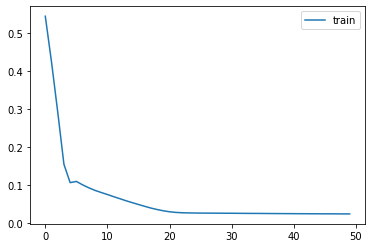

In [61]:

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=50, batch_size=72, verbose=2, shuffle=False)

pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [0]:

yhat = model.predict(test_X)

In [0]:
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])

In [64]:

test_y_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X,test_y_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y

array([[ 2.        ,  0.        , 11.97830105, 12.65442467, 11.76603222,
        11.62321091, 11.48943996, 11.2387886 , 11.18102264, 11.71671486],
       [ 0.        ,  0.        , 12.65442467, 11.76603222, 11.62321091,
        11.48943996, 11.2387886 , 11.18102264, 11.71671486, 12.4652853 ],
       [ 0.        ,  0.        , 11.76603222, 11.62321091, 11.48943996,
        11.2387886 , 11.18102264, 11.71671486, 12.4652853 , 11.43227482],
       [ 0.        ,  0.        , 11.62321091, 11.48943996, 11.2387886 ,
        11.18102264, 11.71671486, 12.4652853 , 11.43227482, 11.62398911],
       [ 0.        ,  0.        , 11.48943996, 11.2387886 , 11.18102264,
        11.71671486, 12.4652853 , 11.43227482, 11.62398911, 11.56952095],
       [ 2.        ,  0.        , 11.2387886 , 11.18102264, 11.71671486,
        12.4652853 , 11.43227482, 11.62398911, 11.56952095, 12.02300072],
       [ 2.        ,  0.        , 11.18102264, 11.71671486, 12.4652853 ,
        11.43227482, 11.62398911, 11.56952095

In [65]:
print(test_X)
print(yhat)
inv_yhat = np.concatenate((test_X,yhat), axis=1)
print (inv_yhat)
inv_yhat = scaler.inverse_transform(inv_yhat)
print (inv_yhat) 


[[1.         0.         0.55767342 0.62840259 0.52866741 0.51263361
  0.49761584 0.46947653 0.46299144]
 [0.         0.         0.63270039 0.52866741 0.51263361 0.49761584
  0.46947653 0.46299144 0.52313081]
 [0.         0.         0.53411873 0.51263361 0.49761584 0.46947653
  0.46299144 0.52313081 0.6071689 ]
 [0.         0.         0.51827037 0.49761584 0.46947653 0.46299144
  0.52313081 0.6071689  0.49119821]
 [0.         0.         0.50342629 0.46947653 0.46299144 0.52313081
  0.6071689  0.49119821 0.51272097]
 [1.         0.         0.47561243 0.46299144 0.52313081 0.6071689
  0.49119821 0.51272097 0.50660612]
 [1.         0.         0.46920235 0.52313081 0.6071689  0.49119821
  0.51272097 0.50660612 0.55751592]
 [0.         0.         0.52864616 0.6071689  0.49119821 0.51272097
  0.50660612 0.55751592 0.53322181]
 [1.         0.         0.61171229 0.49119821 0.51272097 0.50660612
  0.55751592 0.53322181 0.57278861]
 [0.         0.         0.49708289 0.51272097 0.50660612 0.557515

In [66]:
act = [i[9] for i in inv_y] 
pred = [i[9] for i in inv_yhat] 
print(act)
print(pred)


import math
rmse = math.sqrt(mean_squared_error(act, pred))
print('Test RMSE: %.3f' % rmse)

[11.716714859008789, 12.465285301208496, 11.43227481842041, 11.62398910522461, 11.569520950317383, 12.023000717163086, 11.806600570678711, 12.159042358398438, 12.29223346710205, 11.423270225524902, 11.585147857666016, 11.90931224822998, 11.84969711303711, 11.592768669128418, 11.959933280944824, 12.491332054138184, 11.36490249633789, 11.573714256286621, 11.497476577758789, 11.645095825195312, 11.690622329711914, 12.337605476379395, 12.135541915893555, 12.250252723693848, 12.194887161254883, 12.803838729858398, 11.886531829833984, 11.869614601135254, 11.584356307983398, 12.185338973999023, 12.011173248291016, 12.107016563415527, 11.4113130569458, 11.670833587646484, 12.219343185424805, 12.838847160339355, 11.61220645904541, 11.475241661071777, 11.199892044067383, 11.32236099243164, 11.44716739654541, 11.757132530212402, 12.981635093688965, 11.571144104003906, 11.539569854736328, 11.380105972290039, 11.15085506439209, 11.344182014465332, 11.767549514770508, 10.833952903747559, 11.63068485

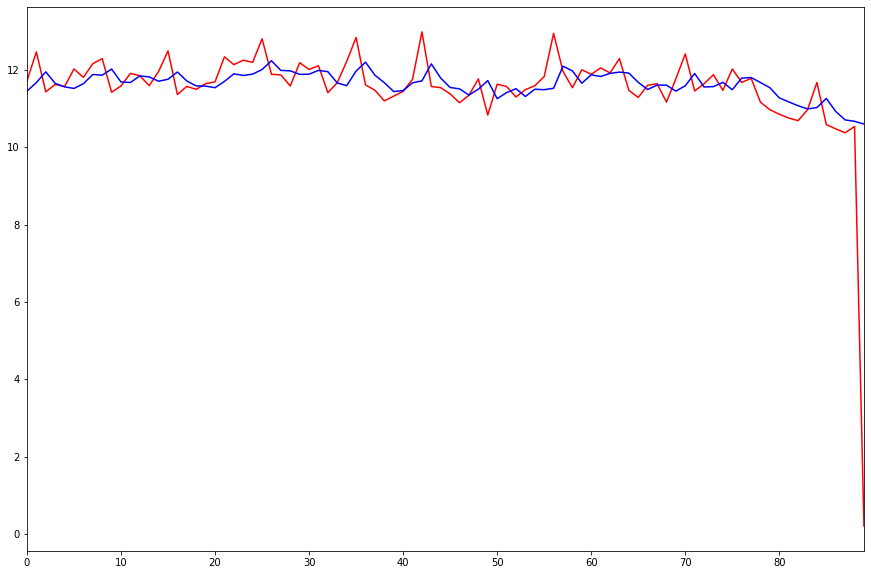

In [67]:
predicted_lstm = pd.DataFrame({'predicted':pred,'avg_energy':act})
predicted_lstm['avg_energy'].plot(figsize=(15,10),color = 'red')
predicted_lstm['predicted'].plot(color = 'blue')
plt.show()